In [1]:

import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import Sequence
from keras.applications import VGG16
from tensorflow.keras.metrics import Accuracy

In [2]:

def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), epsilon=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true + y_pred, axis=axis)
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    return tf.reduce_mean(dice)


In [3]:

# Define la clase del generador de datos
class DataGenerator(Sequence):
    def __init__(self, imagenes, heatmaps, batch_size=16):
        self.imagenes = imagenes
        self.heatmaps = heatmaps
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.imagenes))

    def __len__(self):
        return int(np.ceil(len(self.imagenes) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_x = self.imagenes[start:end]
        batch_y = self.heatmaps[start:end]
        return batch_x, batch_y

In [4]:

# Rutas de los archivos
imagenes_train_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\train\imagenes_originales_train.npy"
imagenes_val_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\val\imagenes_originales_val.npy"
imagenes_test_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\test\imagenes_originales_test.npy"
heatmaps_train_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\train\heatmaps_train.npy"
heatmaps_val_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\val\heatmaps_val.npy"
heatmaps_test_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\test\heatmaps_test.npy"

# Cargar los archivos
imagenes_train = np.load(imagenes_train_path)
heatmaps_train = np.load(heatmaps_train_path)
imagenes_val = np.load(imagenes_val_path)
heatmaps_val = np.load(heatmaps_val_path)
imagenes_test = np.load(imagenes_test_path)
heatmaps_test = np.load(heatmaps_test_path)

# Convertir uint8 tensor a float32 y normalizar imágenes
imagenes_train = imagenes_train.astype('float32') / 255
imagenes_val = imagenes_val.astype('float32') /255
imagenes_test = imagenes_test.astype('float32') /255


In [5]:
heatmaps_train.dtype

dtype('float32')

In [6]:
imagenes_train.dtype

dtype('float32')

In [7]:
print("Tamaño de imagenes_train:", imagenes_train.shape)
print("Tamaño de heatmaps_train:", heatmaps_train.shape)
print("Tamaño de imagenes_val:", imagenes_val.shape)
print("Tamaño de heatmaps_val:", heatmaps_val.shape)
print("Tamaño de imagenes_test:", imagenes_test.shape)
print("Tamaño de heatmaps_test:", heatmaps_test.shape)

Tamaño de imagenes_train: (14918, 112, 112, 3)
Tamaño de heatmaps_train: (14918, 112, 112, 7)
Tamaño de imagenes_val: (2576, 112, 112, 3)
Tamaño de heatmaps_val: (2576, 112, 112, 7)
Tamaño de imagenes_test: (2552, 112, 112, 3)
Tamaño de heatmaps_test: (2552, 112, 112, 7)


In [8]:
# Imprimir el primer elemento de cada array
print("Primer elemento de imagenes_train:")
print(imagenes_train[0])

print("\nPrimer elemento de heatmaps_train:")
print(heatmaps_train[0])

print("\nPrimer elemento de imagenes_val:")
print(imagenes_val[0])

print("\nPrimer elemento de heatmaps_val:")
print(heatmaps_val[0])

print("\nPrimer elemento de imagenes_test:")
print(imagenes_test[0])

print("\nPrimer elemento de heatmaps_test:")
print(heatmaps_test[0])

Primer elemento de imagenes_train:
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.         0.         0.        ]
  

In [9]:

# Cargar el modelo VGG16 preentrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas al modelo
x = base_model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Dropout(0.5)(x)

# Regularización L2
x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(112 * 112 * 7, activation='sigmoid')(x)
x = Dropout(0.5)(x)
output_layer = Reshape((112, 112, 7))(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=output_layer)

# Configurar el checkpoint para guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

# Compilar el modelo
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Crear instancias del generador de datos para entrenamiento y validación
train_generator = DataGenerator(imagenes_train, heatmaps_train, batch_size=16)
val_generator = DataGenerator(imagenes_val, heatmaps_val, batch_size=16)
test_generator = DataGenerator(imagenes_test, heatmaps_test, batch_size=16)

# Entrenar el modelo
history = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint])

# Evaluar el modelo en datos de prueba utilizando el generador
test_loss, test_dice_score = model.evaluate(test_generator)
print(f'Loss en datos de prueba: {test_loss}')
print(f'DICE SCORE en datos de prueba: {test_dice_score}')


Epoch 1/5
933/933 [==============================] - 61s 55ms/step - loss: nan - accuracy: 0.9897 - val_loss: nan - val_accuracy: 0.9910
Epoch 2/5
933/933 [==============================] - 46s 49ms/step - loss: nan - accuracy: 0.9906 - val_loss: nan - val_accuracy: 0.9910
Epoch 3/5
933/933 [==============================] - 43s 46ms/step - loss: nan - accuracy: 0.9906 - val_loss: nan - val_accuracy: 0.9910
Epoch 4/5
933/933 [==============================] - 42s 45ms/step - loss: nan - accuracy: 0.9906 - val_loss: nan - val_accuracy: 0.9910
Epoch 5/5
160/160 [==============================] - 8s 48ms/step - loss: nan - accuracy: 0.9906
Loss en datos de prueba: nan
DICE SCORE en datos de prueba: 0.9905654788017273


In [9]:
model = Sequential()

# Base convolucional
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(112, 112, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# Regularización L2
model.add(Flatten())
model.add(Dense(112, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Dense(112 * 112 * 7, activation='softmax'))  # Cambiado a 'softmax'
model.add(Reshape((112, 112, 7)))

# Configurar el checkpoint para guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Compilar el modelo con la pérdida de entropía cruzada categórica
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  # Cambiado a 'accuracy'

# Crear instancias del generador de datos para entrenamiento y validación
train_generator = DataGenerator(imagenes_train, heatmaps_train, batch_size=16)
val_generator = DataGenerator(imagenes_val, heatmaps_val, batch_size=16)
test_generator = DataGenerator(imagenes_test, heatmaps_test, batch_size=16)

# Entrenar el modelo
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[checkpoint])

# Evaluar el modelo en datos de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Loss en datos de prueba: {test_loss}')
print(f'Accuracy en datos de prueba: {test_accuracy}')


Epoch 1/30
422/933 [============>.................] - ETA: 22s - loss: nan - accuracy: 0.9385

KeyboardInterrupt: 

1/1 [==============================] - 1s 787ms/step


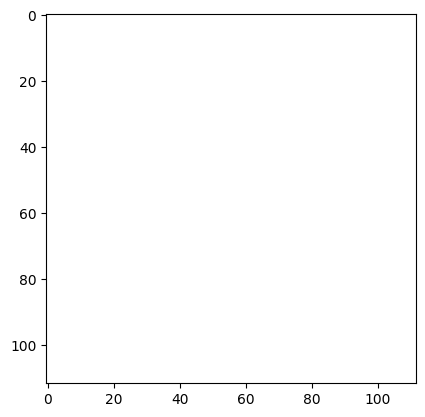

In [ ]:
# Supongamos que 'imagenes_test' es tu conjunto de datos de prueba
imagen_test = imagenes_test[9]  # Tomamos la primera imagen de prueba

import matplotlib.pyplot as plt

# Generar la predicción para la imagen de prueba
prediccion = model.predict(np.expand_dims(imagen_test, axis=0))

# La predicción tendrá la forma (1, 112, 112, 7), por lo que eliminamos la primera dimensión
prediccion = np.squeeze(prediccion)

# Sumamos los canales para obtener una imagen en escala de grises
imagen_salida = np.sum(prediccion, axis=-1)

# Normalizamos la imagen para que sus valores estén entre 0 y 1
imagen_salida = (imagen_salida - np.min(imagen_salida)) / (np.max(imagen_salida) - np.min(imagen_salida))

# Mostramos la imagen
plt.imshow(imagen_salida, cmap='gray')
plt.show()


In [ ]:
# Hacer predicciones en datos de prueba
predictions = model.predict(test_generator)

# Imprimir la forma de las predicciones
print("Shape of predictions:", predictions.shape)

# Puedes acceder a las predicciones de una muestra específica, por ejemplo, la primera muestra
sample_prediction = predictions[0]

# Imprimir las predicciones para cada canal
for channel in range(7):
    channel_prediction = sample_prediction[:, :, channel]
    print(f"Channel {channel+1} Prediction:")
    print(channel_prediction)



160/160 [==============================] - 5s 30ms/step
Shape of predictions: (2552, 112, 112, 7)
Channel 1 Prediction:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Channel 2 Prediction:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Channel 3 Prediction:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Channel 4 Prediction:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Channel 5 Prediction:
[[nan nan nan ... nan na

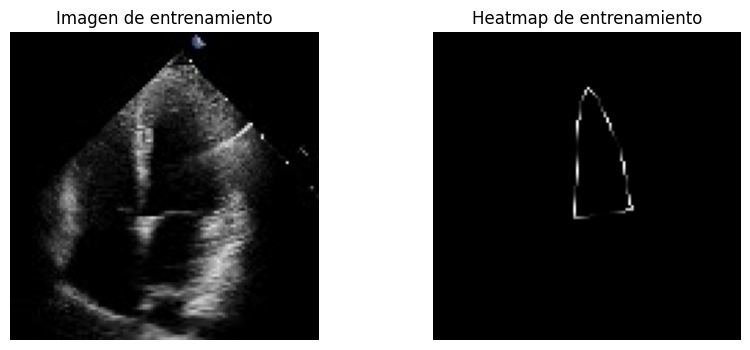

In [4]:
import matplotlib.pyplot as plt

# Seleccionamos la primera imagen de los conjuntos de entrenamiento
imagen = imagenes_val[112]
heatmap = heatmaps_val[112]

# Visualizamos la imagen de entrenamiento
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(imagen)
plt.title('Imagen de entrenamiento')
plt.axis('off')

# Para el heatmap, sumamos los canales para obtener una imagen en escala de grises
heatmap_gris = np.sum(heatmap, axis=-1)

# Normalizamos la imagen para que sus valores estén entre 0 y 1
heatmap_gris = (heatmap_gris - np.min(heatmap_gris)) / (np.max(heatmap_gris) - np.min(heatmap_gris))

plt.subplot(1, 2, 2)
plt.imshow(heatmap_gris, cmap='gray')
plt.title('Heatmap de entrenamiento')
plt.axis('off')

plt.show()
